In [511]:
import os
import math
import heapq
import imageio

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from PIL import Image
from tqdm import tqdm

In [552]:
def load_and_process_environment(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((200, 200))  # Resize to 200 x 200
    img_array = np.array(img)
    img_array = img_array < 200  # Convert to binary image
    return img_array.astype(int)


def plotting_results(plan: list, imgs_path = 'imgs_for_gif/', save_path: str = 'solve_RRT.gif'):
    """
    create an animation of the plan and save it to a file, this function is stolen from PS1
    @param plan: list of joint poses
    @param imgs_path: path to images of which .gif file will be created
    @param save_path: path to save the animation
    """
    fig = plt.figure()
    imgs = []
    
    for s in range(len(plan)):
        im = plt.imread(imgs_path+str(s)+'.png')
        plot = plt.imshow(im)
        imgs.append([plot])
        
    ani = animation.ArtistAnimation(fig, imgs, interval=10, blit=True)
    ani.save(save_path)
    plt.show()


def plot_enviroment(img: np.ndarray, mouse_pos: tuple):
    merged_img = np.copy(img).astype(float)
    merged_img[mouse_pos[0]-1:mouse_pos[0]+2, mouse_pos[1]-1:mouse_pos[1]+2] += 0.5
    return merged_img


def is_free_simple(node, c_space):
    x, y = node
    if 0 <= x < c_space.shape[0] and 0 <= y < c_space.shape[1]:
        return (c_space[x, y] == 0) & \
               (c_space[x+1, y] == 0) & \
               (c_space[x-1, y] == 0) & \
               (c_space[x, y+1] == 0) & \
               (c_space[x+1, y+1] == 0) & \
               (c_space[x-1, y+1] == 0) & \
               (c_space[x, y-1] == 0) & \
               (c_space[x+1, y-1] == 0) & \
               (c_space[x-1, y-1] == 0)
    return False


def distance_fn_simple(pos1, pos2):
    dist = np.abs(pos1[0]-pos2[0]) + np.abs(pos1[1]-pos2[1])
    return dist


def generate_random_pos_simple():
    x = np.random.randint(5, 195)
    y = np.random.randint(5, 195)
    return (x, y)


def find_nearest_simple(pos, G):
    min_dist = distance_fn_simple(pos, start_config)
    nearest = start_config
    for key in G:
        key_state = key
        if min_dist > distance_fn_simple(key_state, pos):
            min_dist = distance_fn_simple(key_state, pos)
            nearest = key_state
    return nearest, min_dist


def get_moving_states_simple(cur_pos, target_pos):
    x_cur = cur_pos[0]
    y_cur = cur_pos[1]
    x_target = target_pos[0]
    y_target = target_pos[1]
    states = [cur_pos]
    while x_cur != x_target:
        x_cur += np.sign(x_target-x_cur)
        states.append((x_cur, y_cur))
    while y_cur != y_target:
        y_cur += np.sign(y_target-y_cur)
        states.append((x_cur, y_cur))
    return states

In [529]:
maze = load_and_process_environment('maze3.jpg')

start_config = (7, 105)
goal_config = (100, 100)

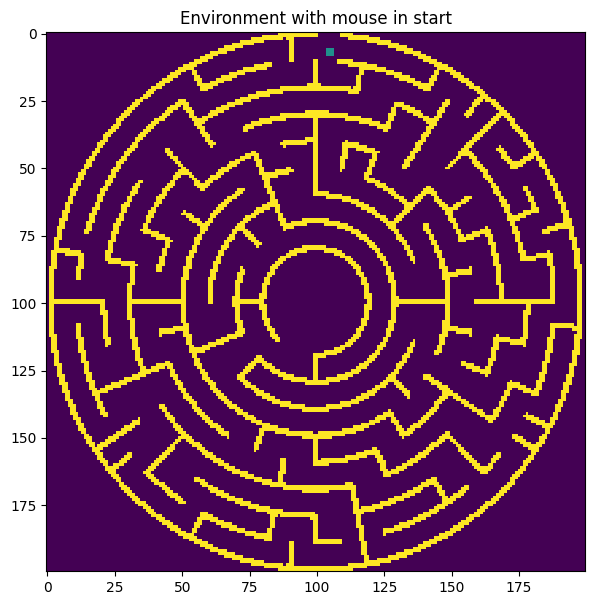

In [513]:
# mouse_shape = create_mouse_shape(45)
env_obj = plot_enviroment(maze, (7, 105))
plt.figure(figsize=(7,7))
plt.title('Environment with mouse in start')
plt.imshow(env_obj, interpolation='none')
plt.show()

In [530]:
def RRT(G1, env, goal_state, n_iter):
    for _ in tqdm(range(n_iter)):
        random_pos = generate_random_pos_simple()
        if _ % 200 == 0:
            random_pos = goal_config
        nearest_pos, dist = find_nearest_simple(random_pos, G1)
        new_poses = get_moving_states_simple(nearest_pos, random_pos)
        for i in range(len(new_poses)-1):
            if is_free_simple(new_poses[i+1], env):
                if new_poses[i+1] not in G1:
                    G1[new_poses[i+1]] = []
                G1[new_poses[i+1]].append(new_poses[i])
                G1[new_poses[i]].append(new_poses[i+1])
            else:
                break
    return G1

In [545]:
G = {tuple(start_config):[]}
G = RRT(G, maze, goal_config, n_iter=55000)

100%|███████████████████████████████████████████████████████████████████████████| 55000/55000 [07:46<00:00, 117.92it/s]


In [546]:
nearest1, dist1 = find_nearest_simple(goal_config, G)

not_visited1 = {}
cost1 = {}
parent_table1 = {tuple(start_config) : tuple(start_config)}
for pos in G:
    not_visited1[pos] = True
    cost1[pos] = 0

In [551]:
cost1[(100, 100)]

754

In [548]:
def dijkstra(start, goal, not_visited, cost, G, parent_table):
    n_steps = 0
    Q = []
    heapq.heapify(Q)
    heapq.heappush(Q, (0, start[0], start[1]))
    while Q:
        n_steps += 1
        price, x0, y0 = heapq.heappop(Q)
        coords = np.array([x0, y0])
        if np.array_equal(coords, np.array(goal)):
            return parent_table, n_steps
        for neighbor in G[tuple(coords)]:
            if not_visited[tuple(neighbor)]:
                not_visited[tuple(neighbor)] = False
                parent_table[tuple(neighbor)] = tuple(coords)
                cost[tuple(neighbor)] = cost[tuple(coords)] + 1
                heapq.heappush(Q, (cost[tuple(neighbor)], neighbor[0], neighbor[1]))
            else:
                if cost[tuple(coords)] + 1 < cost[tuple(neighbor)]:
                    cost[tuple(neighbor)] = cost[tuple(coords)] + 1
                    parent_table[tuple(neighbor)] = tuple(coords)
    print('didnt converge')
    return {}, n_steps


In [549]:
nearest1, dist1 = find_nearest_simple(goal_config, G)
parents1, steps1 = dijkstra(start_config, nearest1, not_visited1, cost1, G, parent_table1)

plan1 = []
key = tuple(nearest1)
while key != tuple(start_config):
    plan1.append(key)
    key = parents1[key]
plan1.append(tuple(start_config))
plan1 = plan1[::-1]

100%|███████████████████████████████████████████████████████████████████████████████| 755/755 [00:01<00:00, 424.20it/s]
MovieWriter ffmpeg unavailable; using Pillow instead.


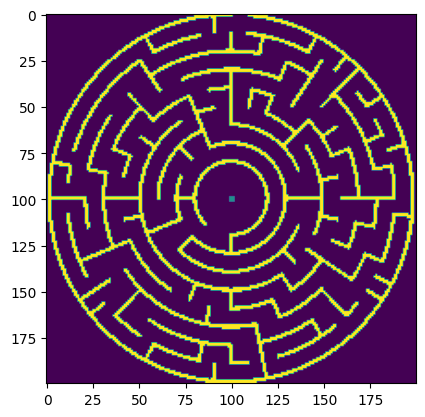

In [553]:
count = 0
# dir_to_save_imgs = 'imgs_for_gif2/'
dir_to_save_imgs = 'imgs_for_gif3/'
if not os.path.isdir(dir_to_save_imgs):
    os.mkdir(dir_to_save_imgs)
for s in tqdm(plan1):
    merged_img = np.copy(maze).astype(float)
    I = plot_enviroment(merged_img, s)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
    img = Image.fromarray(I8)
    img.save(dir_to_save_imgs+str(count)+".png")
    count += 1
    
# plotting_results(plan1, imgs_path = dir_to_save_imgs, save_path = 'solve_RRT.gif')
plotting_results(plan1, imgs_path = dir_to_save_imgs, save_path = 'solve_RRT_2.gif')